In [1]:
import numpy as np

import jax
import jax.numpy as jnp

import crayopt

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

SEED = 111222

rng = jax.random.PRNGKey(SEED)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def nn(x, parameters):
    *hidden, head = parameters

    result = x
    
    for W, b in hidden:
        result = jax.nn.elu(result @ W + b)

    W, b = head
    return result @ W + b

def initialize(key, *units):
    parameters = list()

    for ni, no in zip(units[:-1], units[1:]):
        key, key_W = jax.random.split(key, num=2)
        W = jax.random.normal(key_W, shape=(ni, no))
        b = jnp.zeros(shape=(no, ))

        parameters.append((W, b))
    
    return parameters

In [3]:
SIGMA_NOISE = 1e-1
SIGMA_REG = 3
n_samples = 32 * 1024

rng, key_X, key_eps, key_init = jax.random.split(rng, num=4)

X = jax.random.uniform(key_X, minval=-1, maxval=1, shape=(n_samples, 2))
y = jnp.sum(jnp.square(X), axis=1)[:, None]

y = y + 1e-1 * jax.random.normal(key_eps, shape=y.shape)

initial_parameters = initialize(key_init, 2, 16, 24, 32, 1)

In [4]:
@jax.jit
def loss(X_batch, y_batch, parameters):
    p_batch = nn(X_batch, parameters)

    return 0.5 * n_samples * jnp.mean(jnp.square(p_batch - y_batch)) / jnp.square(SIGMA_NOISE) + 0.5 * sum(
        jnp.sum(jnp.square(w)) for w in jax.tree_util.tree_leaves(parameters)
    ) / jnp.square(SIGMA_REG)

d_loss_d_params = jax.jit(jax.value_and_grad(loss, argnums=2))

In [5]:
from collections import namedtuple
Task = namedtuple('Task', ['method', 'parameters'])

optimizers = dict(
    adam=Task(
        method=crayopt.gradient.adam,
        parameters=dict(
            learning_rate=1e-3,
            beta1=0.9,
            beta2=0.99,
            eps=1e-8
        )
    ),

    laprop=Task(
        method=crayopt.gradient.laprop,
        parameters=dict(
            learning_rate=1e-3,
            mu=0.9,
            nu=0.99,
            eps=1e-8
        )
    ),
    
    adabelief=Task(
        method=crayopt.gradient.adabelief,
        parameters=dict(
            learning_rate=2e-4,
            beta1=0.9,
            beta2=0.99,
            eps=1e-8
        )
    ),

    yogi=Task(
        method=crayopt.gradient.yogi,
        parameters=dict(
            learning_rate=2e-4,
            beta1=0.9,
            beta2=0.99,
            eps=1e-8
        )
    ),
)

In [6]:
BATCH = 32

EPOCHS = 32
ITERATIONS = 1024

losses = dict()

for method in tqdm(optimizers):
    rng_train = rng

    optimizer = optimizers[method].method(**optimizers[method].parameters)

    @jax.jit
    def step(key, X, y, params, state):
        indx = jax.random.randint(key, minval=0, maxval=X.shape[0], shape=(BATCH, ))
        X_batch = X[indx]
        y_batch = y[indx]
        value, gradient = d_loss_d_params(X_batch, y_batch, params)

        return value, *optimizer(params, gradient, state)

    parameters = initial_parameters
    state = optimizer.initial_state(initial_parameters)

    losses[method] = np.ndarray(shape=(EPOCHS, ITERATIONS, ))

    for i in tqdm(range(EPOCHS), desc=method):
        for j in range(ITERATIONS):
            rng_train, key = jax.random.split(rng_train, num=2)
            losses[method][i, j], parameters, state = step(key, X, y, parameters, state)

  0%|          | 0/4 [00:00<?, ?it/s]

adam:   0%|          | 0/32 [00:00<?, ?it/s]

laprop:   0%|          | 0/32 [00:00<?, ?it/s]

adabelief:   0%|          | 0/32 [00:00<?, ?it/s]

yogi:   0%|          | 0/32 [00:00<?, ?it/s]

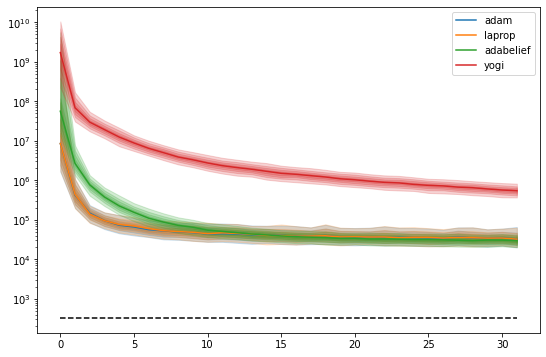

In [7]:
fig = plt.figure(figsize=(9, 6))
axes = fig.subplots()
crayopt.utils.plot.losses(losses, axes=axes)

axes.plot([0, EPOCHS - 1], [n_samples * SIGMA_NOISE ** 2, n_samples * SIGMA_NOISE ** 2], color='black', linestyle='--')

axes.set_yscale('log')